In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os
import re
from tqdm import tqdm, trange

#sns.set_theme()

def load_data_files(path, name=None):
    data = None
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
    else:
        for file in os.listdir(path):
            run = pd.read_csv(os.path.join(path, file), index_col=0)
            if data is None:
                data = run
            else:
                data = data.append(run, ignore_index=True)
    if name is not None:
        data["Name"] = name
    return data

def set_fixed_steps(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in tqdm((range(n_runs))):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range)].index)
            
            if len(ids) == 0:
                print("hin?")
                continue
                
            shuffled_ids = random.sample(ids, len(ids))
            keep_id = shuffled_ids[0]
            drop_ids += shuffled_ids[1:]
            
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in trange(n_runs):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range)].index)
            
            if len(ids) == 0:
                print(rows, s_i, "hin?")
                continue
            
            keep_id = ids[0]
            drop_ids += ids[1:]
            # For all numerical columns but the 'Step'
            for c in data.select_dtypes(include=np.number).columns:
                if c == "Step":
                    continue
                data.at[keep_id, c] = data.loc[ids][c].mean()
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg_index(data, max_steps=10000000, n_index=10):
    drop_ids = []
    for i in tqdm(range(0, len(data), n_index)):
        ids = list(range(i, i + n_index))
        keep_id = ids[-1]
        drop_ids += ids[:-1]
        # For all numerical columns but the 'Step'
        for c in data.select_dtypes(include=np.number).columns:
            if c == "Step":
                continue
            data.at[keep_id, c] = data.loc[ids][c].mean()
    return data.drop(drop_ids)

def plot_runs(runs, x="Step", y="Episode return", estim="mean", err="sd", 
               ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, 
               names=None, colors=None, loc='best'):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 6))
    if ax_xlabel is not None:
        ax.set(xlabel=ax_xlabel)
    if ax_ylabel is not None:
        ax.set(ylabel=ax_ylabel)
    if ylim is not None:
        ax.set(ylim=ylim)
    sns.lineplot(data=runs, x=x, y=y, hue="Name", ax=ax, estimator=estim, errorbar=err, palette=colors)
    if names is not None:
        ax.legend(names, loc=loc, frameon=False)
    else:
        ax.legend(loc=loc, frameon=False)
        
def box_plot_runs(runs, x="Step", y="Mean return", 
             ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, 
             names=None, loc='best'):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 6))
    if ylim is not None:
        ax.set(ylim=ylim, xlabel=ax_xlabel, ylabel=ax_ylabel)
    sns.boxplot(x=x, y=y, hue="Name", data=runs, ax=ax)
    if names is not None:
        ax.legend(names, loc=loc)
    else:
        ax.legend(loc=loc)
        
def load_plot_runs(path, y="Episode extrinsic return"):
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
    else:
        for file in os.listdir(path):
            print(file)
            run = pd.read_csv(os.path.join(path, file), index_col=0)
            run = mov_avg(run, step_range=10000, n_runs=1)
            fig1, ax1 = plt.subplots(figsize=(15, 6))
            ax1.plot(run[y])
            plt.show()

## Case study: relative overgeneralization

#### 4030

100%|███████████████████████████████████████████| 11/11 [00:57<00:00,  5.24s/it]


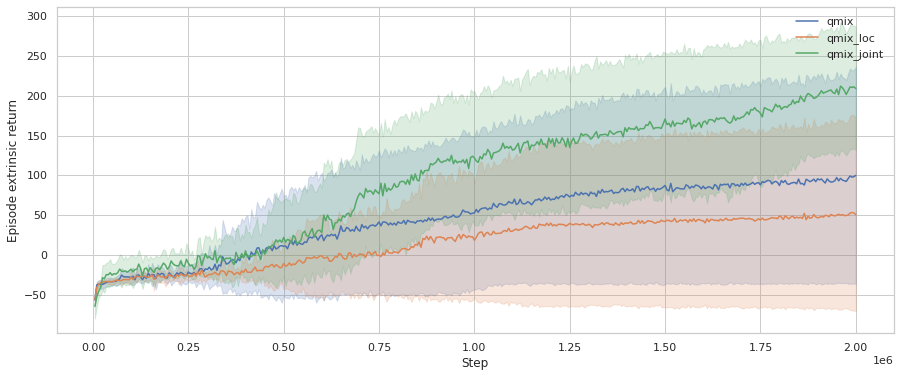

In [68]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_30/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=5000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=5000, n_runs=11)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=5000, n_runs=11)

plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return")

In [ ]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_30/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=20000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=20000, n_runs=15)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=20000, n_runs=11)

plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return")

100%|███████████████████████████████████████████| 11/11 [00:09<00:00,  1.14it/s]


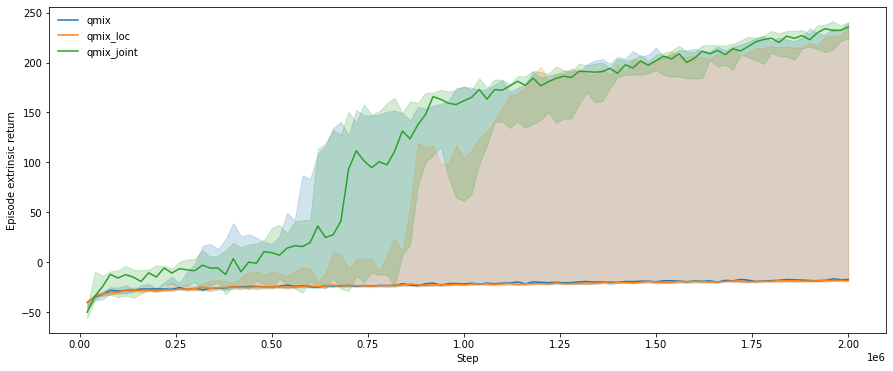

In [5]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_30/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=20000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=20000, n_runs=11)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=20000, n_runs=11)

plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return", estim="median", err="ci")

plot
show


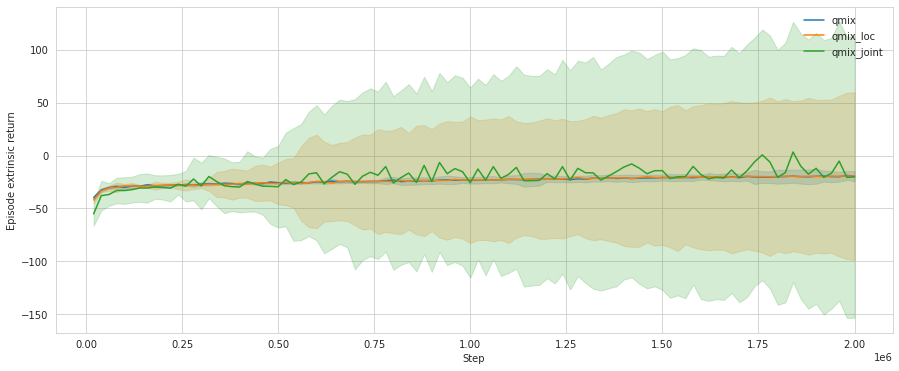

In [23]:
plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return", estim="median")

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.66it/s]


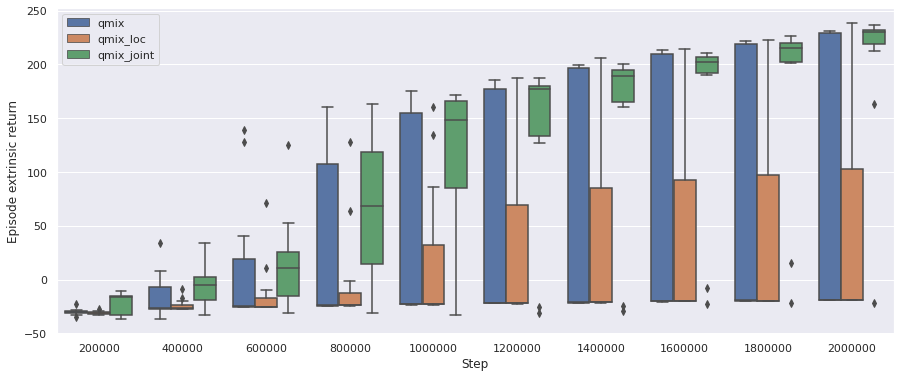

In [3]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_30/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=200000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=200000, n_runs=11)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=200000, n_runs=11)

box_plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return")

#### 4040

100%|███████████████████████████████████████████| 11/11 [00:10<00:00,  1.04it/s]


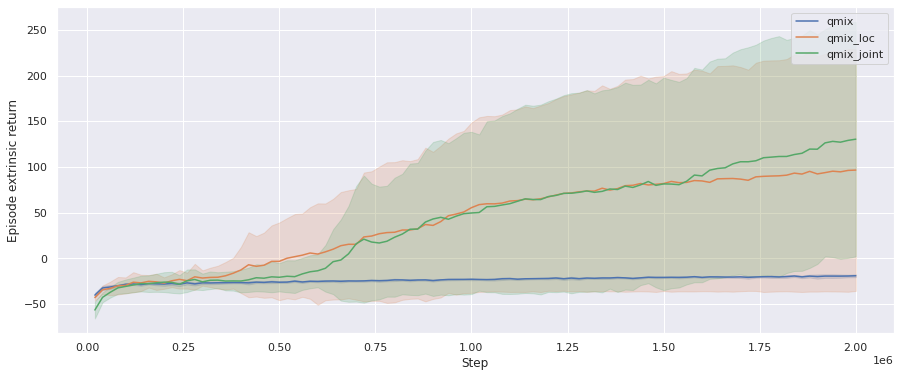

In [9]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_40/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4040/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4040/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=20000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=20000, n_runs=11)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=20000, n_runs=11)

plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return")

100%|███████████████████████████████████████████| 11/11 [00:09<00:00,  1.13it/s]


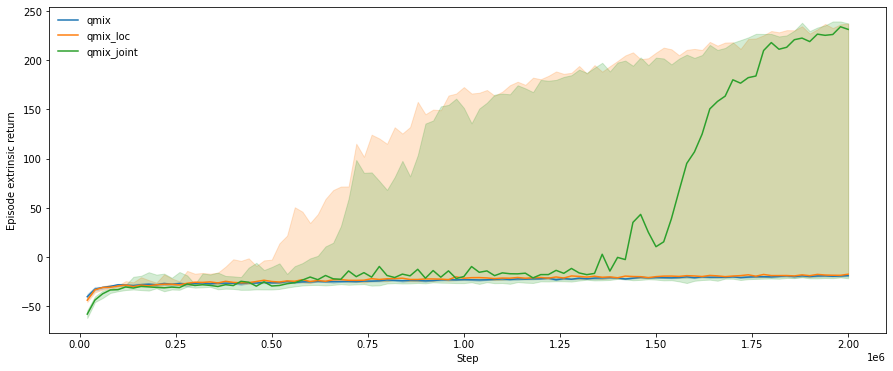

In [8]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_40/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4040/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4040/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=20000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=20000, n_runs=11)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=20000, n_runs=11)

plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return", estim="median", err="ci")

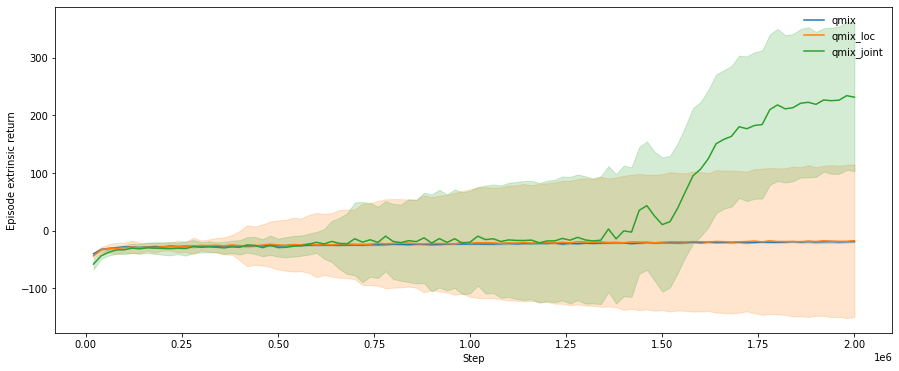

In [9]:
plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return", estim="median")

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.50it/s]


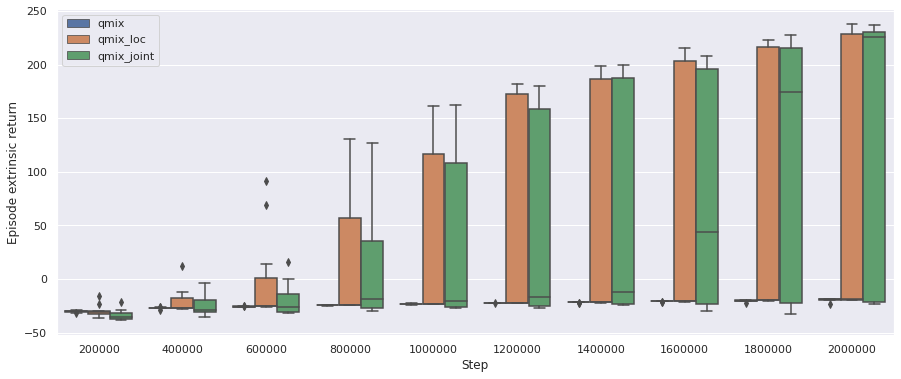

In [5]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_40/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4040/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4040/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=200000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=200000, n_runs=11)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=200000, n_runs=11)

box_plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return")

#### 4050

100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.19s/it]


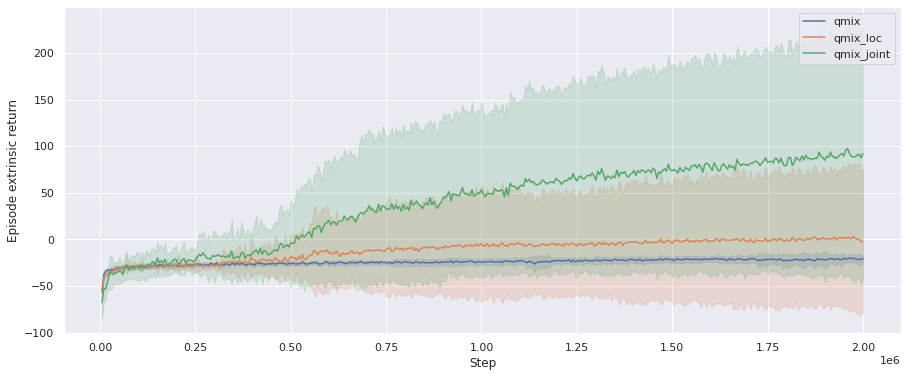

In [6]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_50/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_invdyn_4050/train_data/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_invdyn_4050/train_data/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=5000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=5000, n_runs=11)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=5000, n_runs=11)

plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return")

100%|███████████████████████████████████████████| 11/11 [00:09<00:00,  1.19it/s]


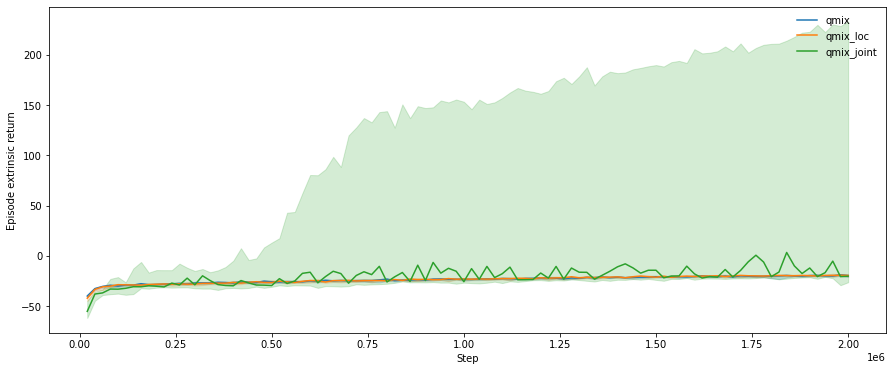

In [10]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_50/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_invdyn_4050/train_data/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_invdyn_4050/train_data/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=20000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=20000, n_runs=11)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=20000, n_runs=11)

plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return", estim="median", err="ci")

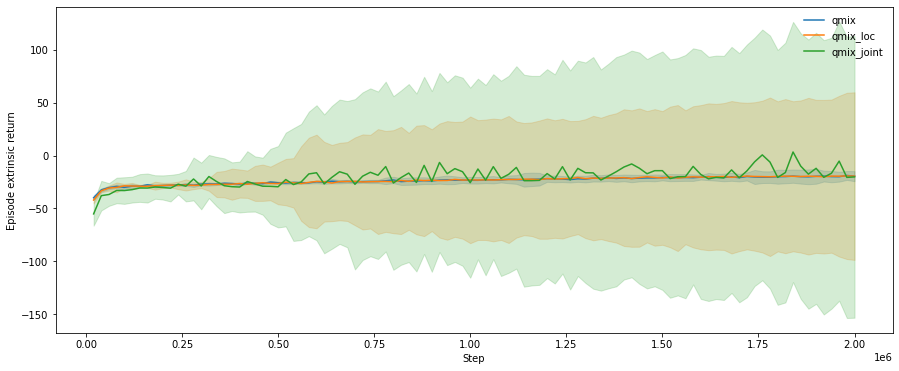

In [11]:
plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return", estim="median")

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.79it/s]


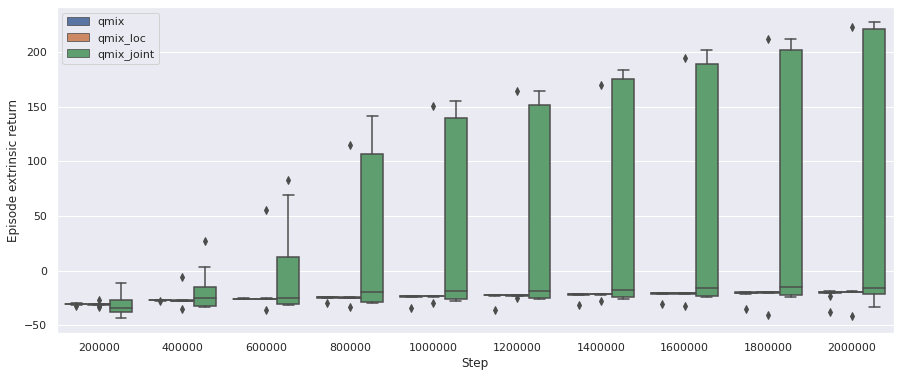

In [7]:
qmix = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_50/",
    name="qmix")
qmix_loc = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_invdyn_4050/train_data/",
    name="qmix_loc")
qmix_joint = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_invdyn_4050/train_data/",
    name="qmix_joint")
qmix = mov_avg(qmix, max_steps=2000000, step_range=200000, n_runs=11)
qmix_loc = mov_avg(qmix_loc, max_steps=2000000, step_range=200000, n_runs=11)
qmix_joint = mov_avg(qmix_joint, max_steps=2000000, step_range=200000, n_runs=11)

box_plot_runs([qmix, qmix_loc, qmix_joint], y="Episode extrinsic return")

#### ALL (final graph)

All three levels together

In [2]:
qmix_30 = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_30/",
    name="qmix")
qmix_loc_30 = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_loc")
qmix_joint_30 = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4030/",
    name="qmix_joint")
ro30 = [
    mov_avg(qmix_30, max_steps=2000000, step_range=20000, n_runs=15), 
    mov_avg(qmix_loc_30, max_steps=2000000, step_range=20000, n_runs=15), 
    mov_avg(qmix_joint_30, max_steps=2000000, step_range=20000, n_runs=15)]
    
qmix_40 = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_40/",
    name="qmix")
qmix_loc_40 = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4040/",
    name="qmix_loc")
qmix_joint_40 = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4040/",
    name="qmix_joint")
ro40 = [
    mov_avg(qmix_40, max_steps=2000000, step_range=20000, n_runs=15), 
    mov_avg(qmix_loc_40, max_steps=2000000, step_range=20000, n_runs=15), 
    mov_avg(qmix_joint_40, max_steps=2000000, step_range=20000, n_runs=15)]
    
qmix_50 = load_data_files(
    "../models/rel_overgen/qmix/train_data_40_50/",
    name="qmix")
qmix_loc_50 = load_data_files(
    "../models/rel_overgen/qmix_loc_e2snoveld_invdyn_4050/train_data/",
    name="qmix_loc")
qmix_joint_50 = load_data_files(
    "../models/rel_overgen/qmix_cent_e2snoveld_invdyn_4050/train_data/",
    name="qmix_joint")
ro50 = [
    mov_avg(qmix_50, max_steps=2000000, step_range=20000, n_runs=15), 
    mov_avg(qmix_loc_50, max_steps=2000000, step_range=20000, n_runs=15), 
    mov_avg(qmix_joint_50, max_steps=2000000, step_range=20000, n_runs=15)]

 73%|███████████████████████████████▌           | 11/15 [00:11<00:04,  1.17s/it]

hin?
hin?
hin?
hin?
hin?
hin?
hin?
hin?
hin?
hin?
hin?
hin?
hin?
hin?
hin?


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.04s/it]


plot
show
plot
show
plot
show


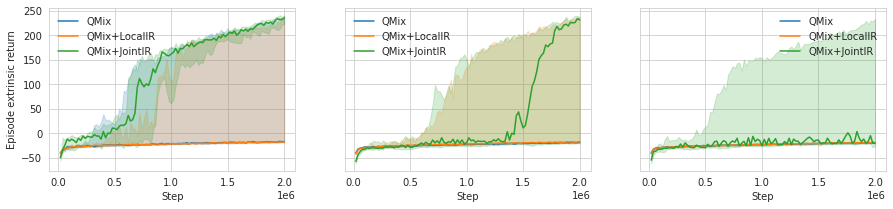

In [32]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
plot_runs(ro30, ax=ax1, y="Episode extrinsic return", names=["QMix", "QMix+LocalIR", "QMix+JointIR"], estim="median", err="ci")
plot_runs(ro40, ax=ax2, y="Episode extrinsic return", names=["QMix", "QMix+LocalIR", "QMix+JointIR"], estim="median", err="ci")
plot_runs(ro50, ax=ax3, y="Episode extrinsic return", names=["QMix", "QMix+LocalIR", "QMix+JointIR"], estim="median", err="ci")

plot
show
plot
show
plot
show


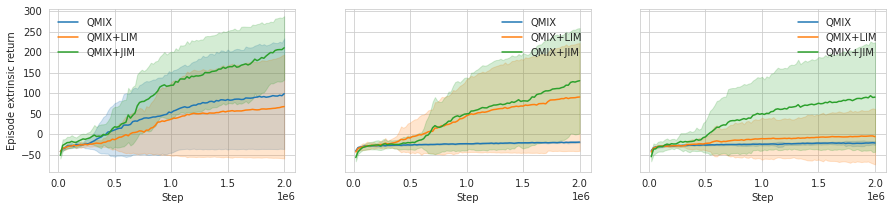

In [33]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
plot_runs(ro30, ax=ax1, y="Episode extrinsic return", names=["QMIX", "QMIX+LIM", "QMIX+JIM"])
plot_runs(ro40, ax=ax2, y="Episode extrinsic return", names=["QMIX", "QMIX+LIM", "QMIX+JIM"])
plot_runs(ro50, ax=ax3, y="Episode extrinsic return", names=["QMIX", "QMIX+LIM", "QMIX+JIM"])

plot
show
plot
show
plot
show


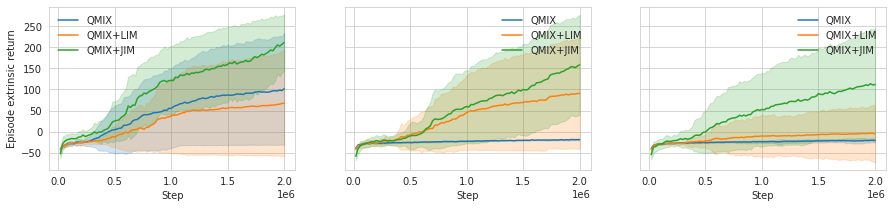

In [3]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
plot_runs(ro30, ax=ax1, y="Episode extrinsic return", names=["QMIX", "QMIX+LIM", "QMIX+JIM"])
plot_runs(ro40, ax=ax2, y="Episode extrinsic return", names=["QMIX", "QMIX+LIM", "QMIX+JIM"])
plot_runs(ro50, ax=ax3, y="Episode extrinsic return", names=["QMIX", "QMIX+LIM", "QMIX+JIM"])

plot
show


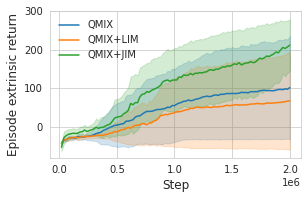

In [23]:
fig, ax = plt.subplots(figsize=(4.5,2.7))
plot_runs(
    ro30, 
    ax=ax, 
    y="Episode extrinsic return", 
    names=["QMIX", "QMIX+LIM", "QMIX+JIM"], 
    loc="upper left",
    ylim=(-80.0, 300.0))
plt.ylabel("Episode extrinsic return", fontsize=12)
plt.xlabel("Step", fontsize=12)
plt.savefig("figures/ro30.jpg", dpi=500, bbox_inches='tight')

plot
show


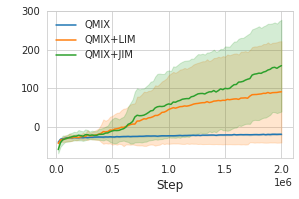

In [26]:
fig, ax = plt.subplots(figsize=(4.4,2.7))
plot_runs(
    ro40, 
    ax=ax, 
    y="Episode extrinsic return", 
    names=["QMIX", "QMIX+LIM", "QMIX+JIM"], 
    loc="upper left",
    ax_ylabel=" ",
    ylim=(-80.0, 300.0))
plt.xlabel("Step", fontsize=12)
plt.savefig("figures/ro40.jpg", dpi=500, bbox_inches='tight')

plot
show


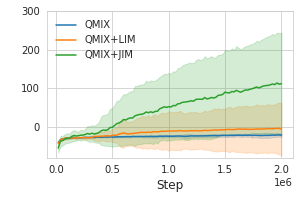

In [27]:
fig, ax = plt.subplots(figsize=(4.4,2.7))
plot_runs(
    ro50, 
    ax=ax, 
    y="Episode extrinsic return", 
    names=["QMIX", "QMIX+LIM", "QMIX+JIM"], 
    loc="upper left",
    ax_ylabel=" ",
    ylim=(-80.0, 300.0))
plt.xlabel("Step", fontsize=12)
plt.savefig("figures/ro50.jpg", dpi=500, bbox_inches='tight')

In [5]:
qmix_30 = load_data_files(
    "../models/rel_overgen/qmix_4030/train_data/",
    name="qmix")
qmix_loc_30 = load_data_files(
    "../models/rel_overgen/qmix_lim_4030/train_data/",
    name="qmix_loc")
qmix_joint_30 = load_data_files(
    "../models/rel_overgen/qmix_jim_4030/train_data/",
    name="qmix_joint")
ro30 = [
    mov_avg(qmix_30, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_loc_30, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_joint_30, max_steps=5000000, step_range=100000, n_runs=15)]
    
qmix_40 = load_data_files(
    "../models/rel_overgen/qmix_4040/train_data/",
    name="qmix")
qmix_loc_40 = load_data_files(
    "../models/rel_overgen/qmix_lim_4040/train_data/",
    name="qmix_loc")
qmix_joint_40 = load_data_files(
    "../models/rel_overgen/qmix_jim_4040/train_data/",
    name="qmix_joint")
ro40 = [
    mov_avg(qmix_40, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_loc_40, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_joint_40, max_steps=5000000, step_range=100000, n_runs=15)]
    
qmix_50 = load_data_files(
    "../models/rel_overgen/qmix_4050/train_data/",
    name="qmix")
qmix_loc_50 = load_data_files(
    "../models/rel_overgen/qmix_lim_4050/train_data/",
    name="qmix_loc")
qmix_joint_50 = load_data_files(
    "../models/rel_overgen/qmix_jim_4050/train_data/",
    name="qmix_joint")
ro50 = [
    mov_avg(qmix_50, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_loc_50, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_joint_50, max_steps=5000000, step_range=100000, n_runs=15)]

100%|███████████████████████████████████████████| 15/15 [00:19<00:00,  1.31s/it]


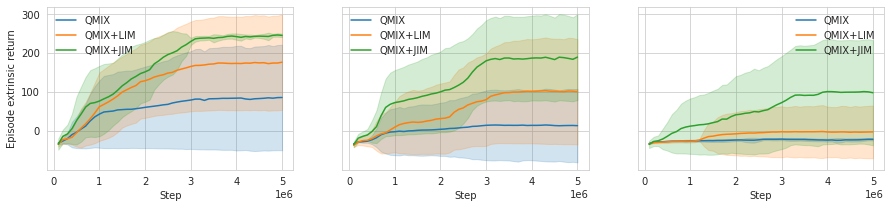

In [6]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
plot_runs(ro30, ax=ax1, y="Episode extrinsic return", names=["QMIX", "QMIX+LIM", "QMIX+JIM"])
plot_runs(ro40, ax=ax2, y="Episode extrinsic return", names=["QMIX", "QMIX+LIM", "QMIX+JIM"])
plot_runs(ro50, ax=ax3, y="Episode extrinsic return", names=["QMIX", "QMIX+LIM", "QMIX+JIM"])

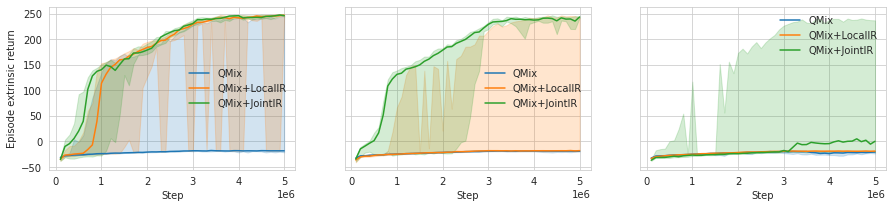

In [7]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
plot_runs(ro30, ax=ax1, y="Episode extrinsic return", names=["QMix", "QMix+LocalIR", "QMix+JointIR"], estim="median", err="ci")
plot_runs(ro40, ax=ax2, y="Episode extrinsic return", names=["QMix", "QMix+LocalIR", "QMix+JointIR"], estim="median", err="ci")
plot_runs(ro50, ax=ax3, y="Episode extrinsic return", names=["QMix", "QMix+LocalIR", "QMix+JointIR"], estim="median", err="ci")

# Push buttons

Partially observable

100%|██████████████████████████████████████| 3000/3000 [00:06<00:00, 496.48it/s]


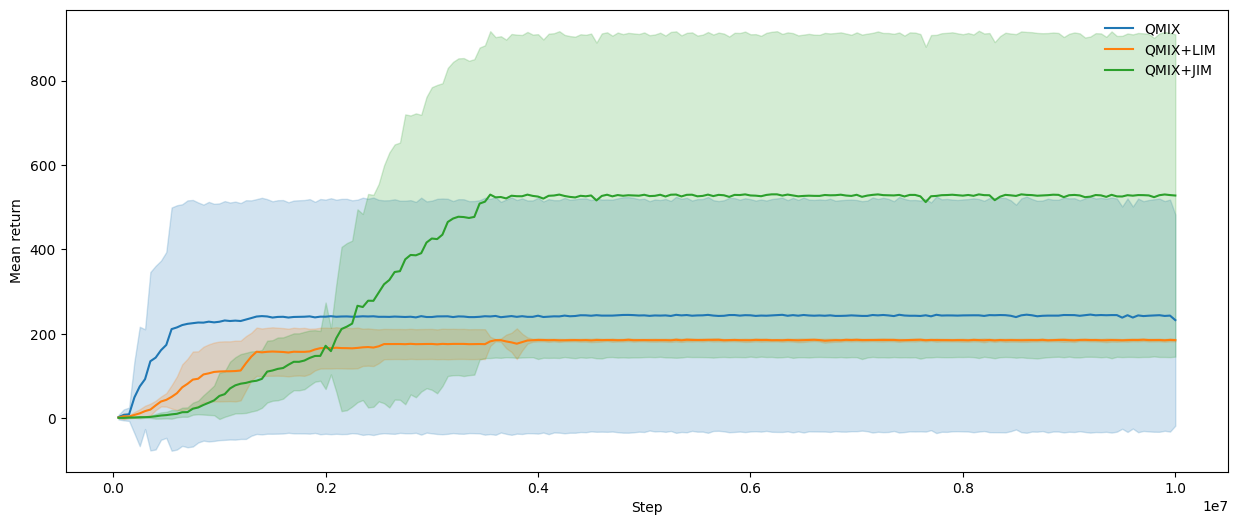

In [36]:
qmix = load_data_files(
    "../models/push_buttons/qmix_pol/train_data/",
    name="QMIX")
lim = load_data_files(
    "../models/push_buttons/qmix_lim_pol/train_data/",
    name="QMIX+LIM")
jim = load_data_files(
    "../models/push_buttons/qmix_jim_pol/train_data/",
    name="QMIX+JIM")
qmix = mov_avg_index(qmix, n_index=5)
lim = mov_avg_index(lim, n_index=5)
jim = mov_avg_index(jim, n_index=5)

plot_runs([qmix, lim, jim], y="Mean return")

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 412.51it/s]


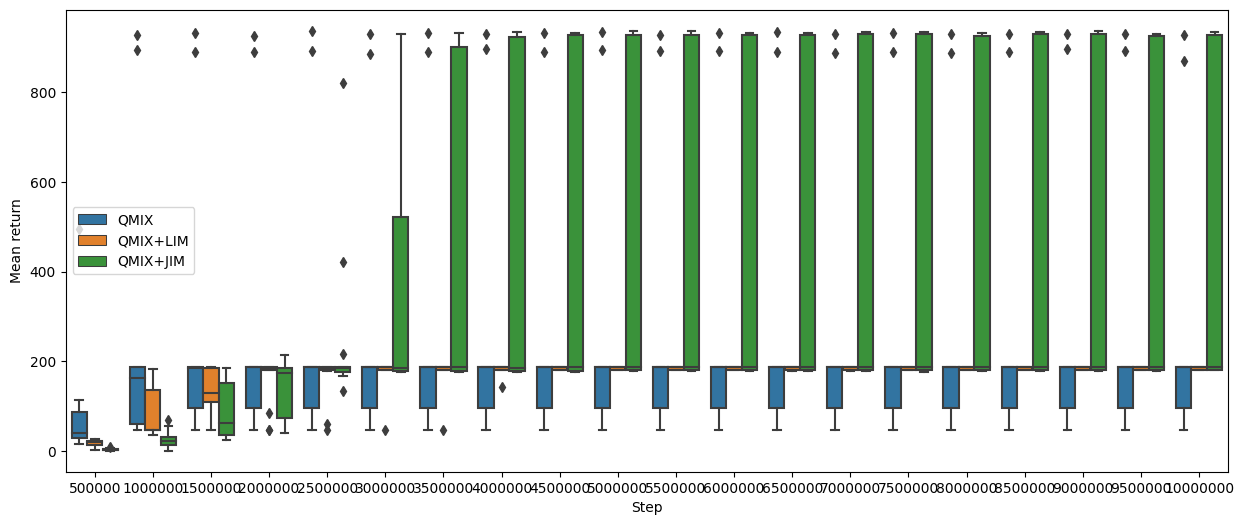

In [37]:
qmix = load_data_files(
    "../models/push_buttons/qmix_pol/train_data/",
    name="QMIX")
lim = load_data_files(
    "../models/push_buttons/qmix_lim_pol/train_data/",
    name="QMIX+LIM")
jim = load_data_files(
    "../models/push_buttons/qmix_jim_pol/train_data/",
    name="QMIX+JIM")
qmix = mov_avg_index(qmix, n_index=50)
lim = mov_avg_index(lim, n_index=50)
jim = mov_avg_index(jim, n_index=50)

box_plot_runs([qmix, lim, jim], y="Mean return")